# Snake

In [5]:
import environments_fully_observable 
import environments_partially_observable
import numpy as np
from  tqdm import trange
import matplotlib.pyplot as plt
import random
import tensorflow as tf
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)
import utils
import DQN
import doubleDQN
# import DDQN
import AStar_Heuristic

## Environment definition

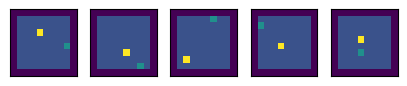

In [7]:
%matplotlib inline
# function to standardize getting an env for the whole notebook
def get_env(n=100, size = 10):
    # n is the number of boards that you want to simulate parallely
    # size is the size of each board, also considering the borders
    # mask for the partially observable, is the size of the local neighborhood
    e = environments_fully_observable.OriginalSnakeEnvironment(n, size)
    # e = environments_partially_observable.OriginalSnakeEnvironment(n, size, 2)
    return e
env_ = get_env(n=300, size=10)
GAMMA = .9
ITERATIONS = 1000
BATCH_SIZE = 32

utils.display_boards(env_, 5)

## Model

In [8]:
input_shape = env_.to_state().shape[1:]

DQN_agent = DQN.DQNAgent(input_shape= input_shape, num_actions= 4, gamma= GAMMA)
Double_DQN_agent = doubleDQN.DoubleDQNAgent(input_shape= input_shape, num_actions= 4, gamma= GAMMA)

if tf.config.list_physical_devices('GPU'):
    print('GPU is available.')
else:
    print('GPU is not available. Switching to CPU.')


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 8, 8, 32)          1184      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 2, 2, 64)          0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 256)              

## Training

In [16]:
ITERATIONS = 5000
BATCH_SIZE = 128
Double_DQN_agent.train(env_, ITERATIONS, BATCH_SIZE)
# DQN_agent.train(env_, ITERATIONS, BATCH_SIZE)

Epoch: 1/5000 | Epsilon: 0.100 | Time: 0.248s
Epoch: 2/5000 | Epsilon: 0.100 | Time: 0.242s
Epoch: 3/5000 | Epsilon: 0.100 | Time: 0.244s
Epoch: 4/5000 | Epsilon: 0.100 | Time: 0.235s
Epoch: 5/5000 | Epsilon: 0.100 | Time: 0.156s
Epoch: 6/5000 | Epsilon: 0.100 | Time: 0.156s
Epoch: 7/5000 | Epsilon: 0.100 | Time: 0.163s
Epoch: 8/5000 | Epsilon: 0.100 | Time: 0.155s
Epoch: 9/5000 | Epsilon: 0.100 | Time: 0.159s
Epoch: 10/5000 | Epsilon: 0.100 | Time: 0.160s
Epoch: 11/5000 | Epsilon: 0.100 | Time: 0.242s
Epoch: 12/5000 | Epsilon: 0.100 | Time: 0.242s
Epoch: 13/5000 | Epsilon: 0.100 | Time: 0.157s
Epoch: 14/5000 | Epsilon: 0.100 | Time: 0.155s
Epoch: 15/5000 | Epsilon: 0.100 | Time: 0.155s
Epoch: 16/5000 | Epsilon: 0.100 | Time: 0.162s
Epoch: 17/5000 | Epsilon: 0.100 | Time: 0.158s
Epoch: 18/5000 | Epsilon: 0.100 | Time: 0.242s
Epoch: 19/5000 | Epsilon: 0.100 | Time: 0.157s
Epoch: 20/5000 | Epsilon: 0.100 | Time: 0.242s
Epoch: 21/5000 | Epsilon: 0.100 | Time: 0.245s
Epoch: 22/5000 | Epsil

  3%|▎         | 3/100 [00:00<00:04, 21.26it/s]

Step: 0/100 | Reward: 0.000


 15%|█▌        | 15/100 [00:00<00:03, 22.08it/s]

Step: 10/100 | Reward: 0.000


 24%|██▍       | 24/100 [00:01<00:03, 22.38it/s]

Step: 20/100 | Reward: 0.000


 33%|███▎      | 33/100 [00:01<00:03, 21.19it/s]

Step: 30/100 | Reward: 0.000


 45%|████▌     | 45/100 [00:02<00:02, 22.04it/s]

Step: 40/100 | Reward: 0.000


 54%|█████▍    | 54/100 [00:02<00:02, 22.47it/s]

Step: 50/100 | Reward: 0.000


 63%|██████▎   | 63/100 [00:02<00:01, 22.53it/s]

Step: 60/100 | Reward: 0.000


 75%|███████▌  | 75/100 [00:03<00:01, 22.72it/s]

Step: 70/100 | Reward: 0.000


 84%|████████▍ | 84/100 [00:03<00:00, 22.64it/s]

Step: 80/100 | Reward: 0.000


 93%|█████████▎| 93/100 [00:04<00:00, 22.11it/s]

Step: 90/100 | Reward: 0.000


100%|██████████| 100/100 [00:04<00:00, 22.20it/s]


Mean Reward: 0.000


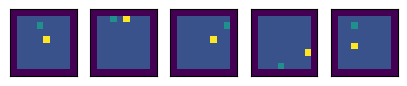

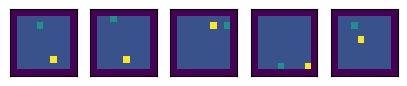

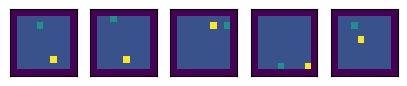

In [21]:
env_test = get_env(n=5, size=10)
input_shape_test = env_test.to_state().shape[1:]
GAMMA = .9
ITERATIONS = 100
utils.display_boards(env_test, 5)
Double_DQN_agent.play_target(env_test, ITERATIONS)
utils.display_boards(env_test, 5)

  0%|          | 0/50 [00:00<?, ?it/s]


InvalidArgumentError: Graph execution error:

Detected at node sequential_2/dense_4/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\traitlets\config\application.py", line 1077, in launch_instance

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 604, in run_forever

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1909, in _run_once

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 80, in _run

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 529, in dispatch_queue

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 518, in process_one

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 424, in dispatch_shell

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\kernelbase.py", line 766, in execute_request

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3048, in run_cell

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3103, in _run_cell

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3308, in run_cell_async

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3490, in run_ast_nodes

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py", line 3550, in run_code

  File "C:\Users\user\AppData\Local\Temp\ipykernel_33684\572300439.py", line 19, in <module>

  File "C:\Users\user\AppData\Local\Temp\ipykernel_33684\572300439.py", line 13, in play

  File "d:\UNIPD\reinforcement learning\RL_Snake\doubleDQN.py", line 60, in select_actions_exploration

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2655, in predict

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 590, in __call__

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\sequential.py", line 398, in call

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py", line 515, in call

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\functional.py", line 672, in _run_internal_graph

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\base_layer.py", line 1149, in __call__

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py", line 255, in call

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\activations.py", line 306, in relu

  File "c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py", line 5395, in relu

Matrix size-incompatible: In[0]: [2,256], In[1]: [1024,512]
	 [[{{node sequential_2/dense_4/Relu}}]] [Op:__inference_predict_function_4074299]

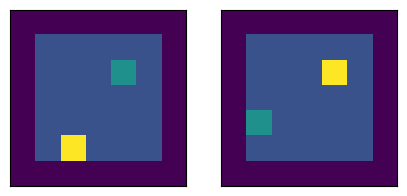

In [ ]:
env_ = get_env(2, size=7)
input_shape = env_.to_state().shape[1:]

GAMMA = .9
ITERATIONS = 50
def play(agent, env, steps=50):
    # fruits = np.zeros(env.n_boards, dtype=int)
    rewards = np.zeros(env.n_boards, dtype=float)[:, None]

    for _ in trange(steps):
        states = env.to_state()
        # print(agent.select_actions_exploitation(states).reshape(-1, 1).shape)
        actions = agent.select_actions_exploration(states).reshape(-1, 1)
        reward = env.move(actions)

        rewards = rewards + reward
        utils.display_boards(env, 2)
utils.display_boards(env_, 2)
play(Double_DQN_agent,env_, steps=ITERATIONS)
# play(env_,DQN_agent, ITERATIONS)
utils.display_boards(env_, 2)


In [ ]:
# ***************************************************************************
# This cell is used for comparing between the RL(DDQN) agent and the A* agent
# ***************************************************************************

import copy

ref_env_ = get_env(5, size=7)
input_shape = ref_env_.to_state().shape[1:]


ITERATIONS = 100

RL_env_ = copy.deepcopy(ref_env_)

DDQN_agent = doubleDQN.DoubleDQNAgent(input_shape= input_shape, num_actions= 4, gamma= GAMMA)
print("weights:" , DDQN_agent.q_model.get_weights()[0][0][0][0][0])
# loading the weights for the DDQN agent *** please change the weights file name ***
DDQN_agent.load_weights("Temp_DDQN")
print("weights:" , DDQN_agent.q_model.get_weights()[0][0][0][0][0])
utils.display_boards(RL_env_, 5)
DDQN_agent.play_target(RL_env_, ITERATIONS)
utils.display_boards(RL_env_, 5)


AStar_env_ = copy.deepcopy(ref_env_)

AStar_agent = AStar_Heuristic.Heuristic_Agent(AStar_env_)
utils.display_boards(AStar_env_, 5)
AStar_agent.execute(ITERATIONS)
utils.display_boards(AStar_env_, 5)


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 5, 5, 64)          2368      
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 2, 2, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_53 (Conv2D)          (None, 2, 2, 128)         73856     
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 1, 1, 128)         0         
 ng2D)                                                           
                                                                 
 conv2d_54 (Conv2D)          (None, 1, 1, 256)         295168    
                                                                 
 flatten_18 (Flatten)        (None, 256)             

ValueError: Cannot assign value to variable ' dense_36/kernel:0': Shape mismatch.The variable shape (256, 512), and the assigned value shape (1024, 512) are incompatible.

rewards:  [[ 7.94999988  7.94999988]
 [12.04999984 12.04999984]]


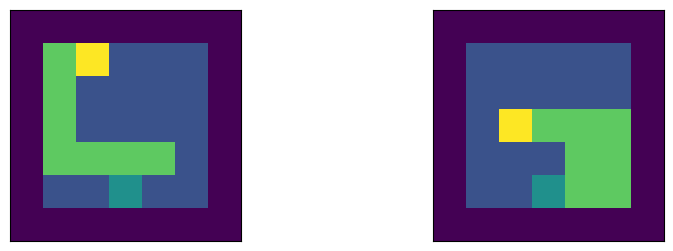

In [ ]:
import AStar_Heuristic

agent = AStar_Heuristic.Heuristic_Agent(env_)
agent.execute(ITERATIONS)


In [ ]:
for iteration in trange(ITERATIONS):
    # get current state of the boards
    state = env_.to_state()
    
    with tf.GradientTape(persistent=True) as tape:
        """ 
        tensor of actions, consider that
            UP = 0
            RIGHT = 1
            DOWN = 2
            LEFT = 3
        """
        actions = [DQN_agent.select_action(state[i]) for i in range(env_.n_boards)]
        rewards = env_.move(actions)
        new_state = tf.constant(env_.to_state())

        # calculate the loss of whichever algorithm you have picked
        loss = ...

    gradient = tape.gradient(..., ...)
    optimizer.apply_gradients(zip(gradient, ...))

  0%|          | 0/50 [00:00<?, ?it/s]


AttributeError: 'DQNAgent' object has no attribute 'select_action'

 ### Random policy reward
 
Just a baseline (not the one you are supposed to develop)

In [ ]:
random_env = get_env(100)
random_rewards = []

for _ in trange(1000):
    probs = tf.convert_to_tensor([[.25]*4]*random_env.n_boards)
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)
    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(np.mean(rewards))

In [25]:
import gym
from stable_baselines3 import A2C
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import tensorflow as tf
from torch.nn import ReLU

class SnakeEnvironmentWrapper(gym.Env):
    def __init__(self, n_boards, board_size):
        self.env = environments_fully_observable.OriginalSnakeEnvironment(n_boards, board_size)
        self.action_space = gym.spaces.Discrete(5)  # 5 possible actions
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=self.env.boards.shape)

    def reset(self):
        return self.env.to_state()

    def step(self, action):
        reward = self.env.move(action)
        return self.env.to_state(), reward, False, {}

# Define the neural network model
def create_mlp(observation_space, action_space):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=observation_space.shape),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(action_space.n, activation=None)
    ])
    return model

# Create the Snake environment
snake_env = SnakeEnvironmentWrapper(n_boards=1, board_size=10)
obs = np.expand_dims(snake_env.reset(), axis=0)


# Vectorize the environment
vec_env = DummyVecEnv([lambda: snake_env])

# Create the MLP model
model = create_mlp(snake_env.observation_space, snake_env.action_space)

# Wrap the model as an A2C agent
agent = A2C("MlpPolicy", vec_env, policy_kwargs=dict(activation_fn=ReLU), verbose=1)

# Train the agent
agent.learn(total_timesteps=10000)

# Play the game with the trained agent
obs = snake_env.reset()
done = False
while not done:
    action, _ = agent.predict(obs)
    obs, reward, done, _ = snake_env.step(action)
    snake_env.env.render()  # You need to implement a render method in your environment for visualization


Using cpu device


ValueError: could not broadcast input array from shape (10,10,4) into shape (1,10,10)